<a href="https://colab.research.google.com/github/bulavk1n/Chest_X-Ray_Pneumonia_Detection/blob/master/TL_Chest_X-Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning - Inception V3 model
In this notebook we are going to apply Transfer Learning to classify some
chest X-ray images having pneumonia (or not!).


We will be using a pretrained Inception V3 model. The dataset has been
taken from [Kaggle Pneumonia Dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/)

Setting up Colab environment. Runtime swithed to GPU.

In [0]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import urllib.request
import seaborn as sns
import tensorflow as tf
import numpy as np
import random

# Tensorflow and Keras 
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, \
  GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3, \
  preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, \
  ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Some utils 
from itertools import product
from functools import partial

Mount our Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from google.colab import files
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bulavk1n","key":"ab86734f78dbe20109a5902713d6f3de"}'}

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


Download our Dataset from Kaggle

In [0]:

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/drive/My\ Drive/kaggle/Chest_X-Ray/

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
os.chdir('/content/drive/My Drive/kaggle/Chest_X-Ray/')

In [0]:

!unzip chest-xray-pneumonia.zip
!unzip chest_xray.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          
Archive:  chest_xray.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
   creating: __MACOSX/chest_xray/test/PNEUMONIA/
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person78_bacteria_382.jpeg  
  inflating: chest_xray/test/PNEUMONIA/

In [0]:
filepath = '/content/drive/My Drive/kaggle/Chest_X-Ray/chest_xray/'

train_dir =  filepath + 'train/'
validation_dir = filepath + 'val/'
test_dir = filepath + 'test/'

Let's see how pictures look like:chest_xray/test/NORMAL/IM-0046-0001.jpeg

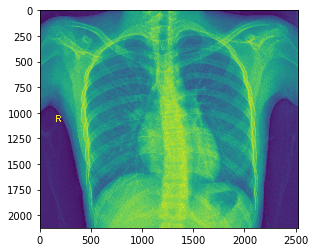

In [0]:
img = mpimg.imread(test_dir + '/NORMAL/IM-0028-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

Viualize more pictures:

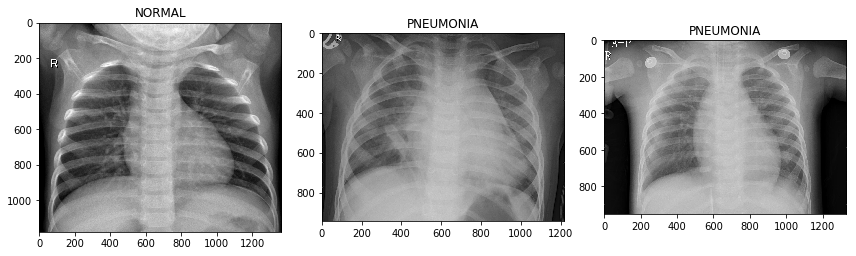

In [0]:
# Normal 
img_normal = plt.imread(f'{train_dir}NORMAL/IM-0665-0001.jpeg')
# Bacterial
img_penumonia_bacteria = plt.imread(f'{train_dir}PNEUMONIA/person488_bacteria_2061.jpeg')
# Viral
img_penumonia_virus = plt.imread(f'{train_dir}PNEUMONIA/person1420_virus_2431.jpeg')

# Plot Configuration
plt.figure(figsize=(12, 5))
plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')
plt.subplot(1,3,2).set_title('PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')
plt.subplot(1,3,3).set_title('PNEUMONIA')
plt.imshow(img_penumonia_virus, cmap='gray')

plt.tight_layout()

# Model using Inception v3
We will be doing transfer learning using the Inception V3 pretrained model. 

In [0]:
# The number of classes we are trying to classify are 2
# Normal or Pneumonia
NUM_CLASSES = 2

# Build the Model
def create_model(input_shape, num_classes):
  """
  Creates the image classifier model on top of a
  pretrained Inception v3.

  Parameters
  ----------
  input_shape : Tuple    
      Shape tuple for Inception v3
  
  num_classes : Integer
      The number of classes that the classifier is 
      going to classify

  Returns
  -------
  The tensorflow model.  
  """
  # We start with a blank slate
  K.clear_session()

  # Inception v3 is our base model
  base_model = InceptionV3(weights='imagenet', include_top=False,\
                           input_shape=input_shape)
  
  # Add our custom layers on top for classification
  x = base_model.output
  x = GlobalAveragePooling2D(name='avg_pool')(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  
  # We are using the base model only for feature extraction
  # So we make sure the layer weights don't change 
  for layer in base_model.layers:
    layer.trainable = False

  # The final predictions layer is going to be a dense layer
  # with Sigmoid activations - predicts only 'num_classes'    
  predictions = Dense(num_classes, activation='sigmoid')(x)
  # Instantiate the model 
  model = Model(inputs=base_model.inputs, outputs=predictions)

  return model


# Creat the model with Height & Width as 150 and 3 channels for Inception
# And we are going to predict only 2 classes in our case
model = create_model((150, 150, 3), NUM_CLASSES)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
87916544/87910968 [==============================] - 7s 0us/step


In [0]:
# Training loss
training_loss = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
# Training Accuracy
training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'training_accuracy', dtype=tf.float32)
# Test Loss 
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
# Test Accuracy 
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'test_accuracy', dtype=tf.float32)

# Print model summary 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
# We use the standard Adam Optimizer 
optimizer = Adam(lr=0.0001)

# Compile 
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

# Feature Engineering

In [0]:
def dir_file_count(directory):
  """
  Counts the total number of files in a directory. 

  Parameters
  ----------
  directory : String    
      The directory isnide which the function is going
      to count the number of files 
  
  Returns
  -------
  Total number of files present inside the 'directory'.  
  """
  return sum([len(files) for r, d, files in os.walk(directory)])

In [0]:
# Configuration parameters 
rescale = 1./255
target_size = (150, 150)
batch_size = 500
class_mode = 'categorical'

# Augment the Training dataset images 
train_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
# Load the images in the generator 
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=target_size,
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)
# Augment the validation dataset images
val_datagen = ImageDataGenerator(rescale=rescale)
# Load the images in the generator
val_generator = val_datagen.flow_from_directory(validation_dir, 
                                                target_size=target_size,
                                                class_mode=class_mode,
                                                batch_size=dir_file_count(validation_dir),
                                                shuffle=False)
# Augment the test dataset images
test_datagen = ImageDataGenerator(rescale=rescale)
# Load the images in the generator
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=dir_file_count(test_dir),
                                                  shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
y = train_generator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight('balanced', labels, y)
print(train_class_weights)

[1.9448173  0.67303226]


# Model training
It's time to train the Model


We will be training for 50 epochs only as after a few hit and
trials it becomes apparent that the model starts to overfit beyond that.

In [0]:
# Start the training
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=50,
                              verbose=1,
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              class_weight=train_class_weights,
                              workers=20)

# Save the model after the training is complete
MODEL_FILE = 'pneumonia_v1.hd5'
model.save(MODEL_FILE)

Epoch 1/50
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
11/11 [==============================] - 108s 10s/step - loss: 0.6120 - acc: 0.7235 - val_loss: 1.1042 - val_acc: 0.5000
Epoch 2/50
11/11 [==============================] - 70s 6s/step - loss: 0.5429 - acc: 0.7454 - val_loss: 0.9022 - val_acc: 0.5000
Epoch 3/50
11/11 [==============================] - 82s 7s/step - loss: 0.4759 - acc: 0.7701 - val_loss: 0.6843 - val_acc: 0.4375
Epoch 4/50
11/11 [==============================] - 84s 8s/step - loss: 0.4089 - acc: 0.8276 - val_loss: 0.7052 - val_acc: 0.7500
Epoch 5/50
11/11 [==============================] - 83s 8s/step - loss: 0.3464 - acc: 0.8553 - val_loss: 1.2018 - val_acc: 0.6250
Epoch 6/50
11/11 [==============================] - 83s 8s/step - loss: 0.3170 - acc: 0.8712 - val_loss: 1.2297 - val_acc: 0.6875
Epoch 7/50
11/11 [==============================] - 85s 8s/step - loss: 0.2904 - acc: 0.8834 - val_loss: 1.1242 - val_acc: 0

In [0]:
# Move the trained model to the Google Drive 
!mv {MODEL_FILE} '/content/drive/My Drive/kaggle/Chest_X-Ray/'

# Model Evaluation
Let's see how well our Model does on the Training Set.

In [0]:
# Load the Model from Google Drive 
MODEL_FILE = 'pneumonia_v1.hd5'
model = tf.keras.models.load_model(MODEL_FILE)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# Run the model on Test Data 
result = model.evaluate_generator(test_generator, steps=len(test_generator),\
                                  verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

1/1 [==============================] - 17s 17s/step - loss: 1.4564 - acc: 0.7179
Loss     : 1.46  
Accuracy : 71.79%


In [0]:
# Randomly generate the Test Batch No
num_of_batch = len(test_generator) # This is 1 in our case 
batch_no = random.randint(0, num_of_batch - 1)

# Fetch the batch data
y_img_batch, y_true_batch = test_generator.__getitem__(batch_no)
y_true_batch = y_true_batch.argmax(axis=-1)

# Make the predictions 
y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)

# Print the results 
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true_batch==y_pred_batch)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 624
-----------------------------------
Accuracy                : 71.79%
-----------------------------------
